# Preprocessing

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
df = pd.read_csv('facial-keypoints-detection/training.csv')

In [3]:
y_full = df.drop(columns=['Image']).values.astype(np.float32)
x_full = [[int(n) for n in img_str.split()] for img_str in df['Image']]
x_full = np.array(x_full, dtype=np.float32).reshape((-1, 96, 96, 1)) / 255

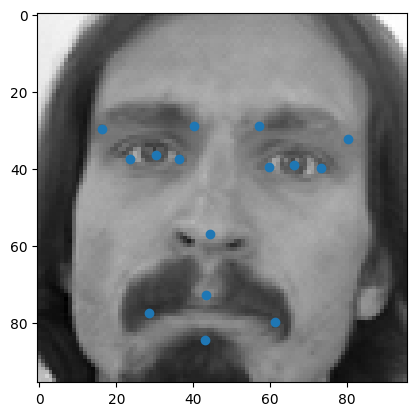

In [4]:
plt.imshow(x_full[0], cmap='grey')
key_points = y_full[0].reshape((-1, 2))
plt.scatter(key_points[:, 0], key_points[:, 1])
plt.show()

In [5]:
from sklearn.model_selection import train_test_split
from sklearn.impute import KNNImputer

x_train_full, x_test, y_train_full, y_test = train_test_split(
    x_full, 
    y_full,
    test_size=0.125,
    shuffle=True,
    random_state=0,
)

imputer = KNNImputer()
y_train_full = imputer.fit_transform(y_train_full)

x_train, x_valid, y_train, y_valid = train_test_split(
    x_train_full, 
    y_train_full,
    test_size=0.15,
    shuffle=True,
    random_state=0,
)

print(f'{len(x_train)} train, {len(x_valid)} valid, {len(x_test)} test')

5241 train, 926 valid, 882 test


# Model

In [6]:
import tensorflow as tf
from keras import models, layers, losses, optimizers, callbacks

In [7]:
model = models.Sequential((
    layers.Input(shape=(96, 96, 1)),
    layers.Conv2D(64, (3, 3), 
                  padding='same', 
                  activation=tf.nn.relu, 
                  use_bias=False),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(32, (3, 3),
                  padding='same', 
                  activation=tf.nn.relu, 
                  use_bias=False),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(16, (3, 3), 
                  padding='same', 
                  activation=tf.nn.relu, 
                  use_bias=False),
    layers.BatchNormalization(),
    layers.Flatten(),
	layers.Dense(128, activation=tf.nn.relu),
	layers.Dense(30),
))

model.compile(
    optimizer=optimizers.Adam(learning_rate=0.001, weight_decay=0.1),
    loss=losses.mean_squared_error,
    metrics=[tf.metrics.R2Score()]
)

callback = callbacks.LearningRateScheduler(lambda _, lr: lr * 0.9)

In [12]:
_ = model.fit(x_train, y_train, 
              batch_size=100, 
              epochs=50, 
              callbacks=[callback],
              verbose=False)

In [13]:
_ = model.evaluate(x_valid, y_valid)

29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 5.7141 - r2_score: 0.4343


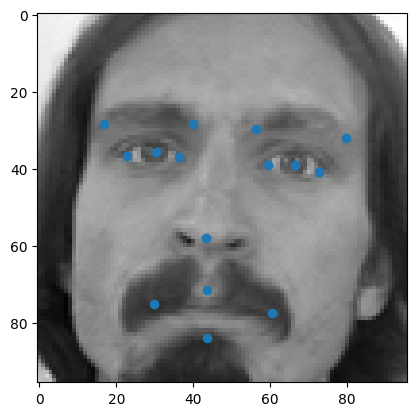

In [19]:
plt.imshow(x_full[0], cmap='grey')
y_hat = model(x_full[:1]).numpy()
key_points = y_hat[0].reshape((-1, 2))
plt.scatter(key_points[:, 0], key_points[:, 1])
plt.show()

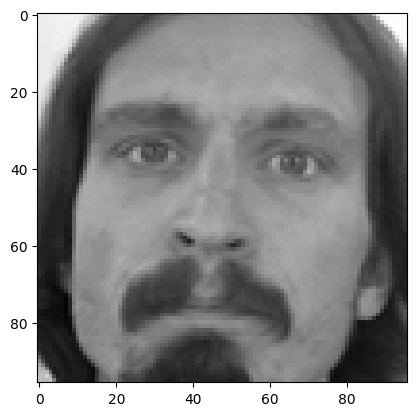

In [17]:
plt.imshow(x_full[0], cmap='grey')

In [18]:
y_full[0]

array([66.03356 , 39.002274, 30.227007, 36.421677, 59.582077, 39.647423,
       73.13035 , 39.969997, 36.35657 , 37.3894  , 23.452871, 37.3894  ,
       56.953262, 29.033648, 80.22713 , 32.228138, 40.227608, 29.002321,
       16.356379, 29.64747 , 44.42057 , 57.066803, 61.19531 , 79.97017 ,
       28.614496, 77.38899 , 43.312603, 72.935455, 43.130707, 84.48577 ],
      dtype=float32)

In [21]:
y_hat = model(x_full[:1]).numpy()[0]
y_hat

array([66.30206 , 39.1732  , 30.234814, 35.794415, 59.448906, 39.121437,
       72.74652 , 40.81077 , 36.316288, 37.086517, 22.844654, 36.704918,
       56.294678, 29.765903, 79.68474 , 32.00304 , 39.958183, 28.502522,
       16.782396, 28.407589, 43.30018 , 58.138752, 60.55122 , 77.5262  ,
       29.673988, 75.296036, 43.61586 , 71.52833 , 43.486504, 83.914955],
      dtype=float32)